In [1]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

from scipy.stats import kurtosis,skew

plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings("ignore")
import gc

<h1>Things to compare</h1>
<div>
<ul>
  <li>Z: Baseline </li>
  <li>A: Theta ^ 2 </li>
  <li>B: abs(Theta) + sqrt(abs(Theta) ^ 2)</li>
  <li>C: Theta </li>
  <li>D: sqrt(Theta ^ 2)</li>
  <li>E: abs(Theta) </li>
  <li>F: sqrt(abs(Theta) ^ 2)</li>
  <li>G: sqrt(Theta ^ 2)/Theta</li>
  <li>H: - tanh(Theta)</li>
  <li>I: - tanh(Theta ^ 2)</li>
  <li>J: - log(1+Theta ^ 2)</li>
</ul>
</div>

In [2]:
# read all of the data
# https://github.com/mttk/STL10
plt.rcParams.update({'font.size': 10})
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
def show_images(data,row=1,col=1):
    fig=plt.figure(figsize=(10,10))
    columns = col; rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(data[i-1])
    plt.show()

train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

label_encoder= OneHotEncoder(sparse=False,categories='auto')
train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

print(train_images.shape,train_images.max(),train_images.min())
print(train_labels.shape,train_labels.max(),train_labels.min())
print(test_images.shape,test_images.max(),test_images.min())
print(test_labels.shape,test_labels.max(),test_labels.min())

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


In [3]:
# create the layers
def tf_softmax(x): return tf.nn.softmax(x)

def tf_elu(x):   return tf.nn.elu(x)
def d_tf_elu(x): return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_relu,d_act=d_tf_relu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.regularizer    = which_reg
        
    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return self.layer, self.layerA
    
    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        if self.regularizer == 'A': grad = grad + lamda * 2.0 * self.w
        if self.regularizer == 'B': grad = grad + lamda * 0.5 * (tf.sign(self.w) + (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-8)) * tf.abs(self.w) * tf.sign(self.w))
        if self.regularizer == 'C': grad = grad + lamda * tf.ones_like(self.w)
        if self.regularizer == 'D': grad = grad + lamda * (1.0/tf.sqrt(tf.square(self.w)+ 10e-8)) * self.w
        if self.regularizer == 'E': grad = grad + lamda * tf.sign(self.w)
        if self.regularizer == 'F': grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-8)) * tf.abs(self.w) * tf.sign(self.w)
        if self.regularizer == 'G': grad = grad + lamda * ( self.w**2/(tf.sqrt(self.w)+10e-8) - tf.sqrt(self.w ** 2))/(self.w**2 + 10e-8)
        if self.regularizer == 'H': grad = grad + lamda * -1.0 * (1.0-tf.tanh(self.w) ** 2)
        if self.regularizer == 'I': grad = grad + lamda * -1.0 * (1.0-tf.tanh(self.w ** 2) ** 2) * 2.0 * self.w
        if self.regularizer == 'J': grad = grad + lamda * -1.0 * (1/(1+self.w ** 2)) * 2.0 * self.w
        
        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        
        return grad_pass,grad,update_w
    
def save_to_image(data,name):
    l1g,l2g,l3g,l4g,l5g,l6g = data
    l1g,l2g,l3g,l4g,l5g,l6g = np.asarray(l1g),np.asarray(l2g),np.asarray(l3g),np.asarray(l4g),np.asarray(l5g),np.asarray(l6g)
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1g.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2g.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3g.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4g.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5g.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6g.ravel(),50); plt.title('layer 6')
    plt.savefig(name + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')     
    
def append_stat(current_list,data,number):
    current_list[0].append(data[number].mean())
    current_list[1].append(data[number].std())
    current_list[2].append(skew    (data[number].ravel()))
    current_list[3].append(kurtosis(data[number].ravel()))
    current_list[4].append(np.count_nonzero(data[number]))
    return current_list

def transform_to_2d(data):
    batch,width,height,chan = data.shape
    return data.reshape((batch*width,height*chan))

def save_to_image(main_data,one,two,three,four,five,six,experiment_name,tran_acc,test_acc,current_exp,iter):
    plt.figure(figsize=(20,40))
    G = gridspec.GridSpec(8, 6)

    plt.figtext(0.5,1.0,"Iter: " + str(iter) + " Histogram Per " + experiment_name,ha="center", va="top", fontsize=35, color="black")
    plt.subplot(G[0, 0]).hist(main_data[0].ravel(),50,color='red');       plt.subplot(G[0, 0]).set_title(experiment_name+' 1')
    plt.subplot(G[0, 1]).hist(main_data[1].ravel(),50,color='orange');    plt.subplot(G[0, 1]).set_title(experiment_name+' 2')
    plt.subplot(G[0, 2]).hist(main_data[2].ravel(),50,color='yellow');  plt.subplot(G[0, 2]).set_title(experiment_name+' 3')
    plt.subplot(G[0, 3]).hist(main_data[3].ravel(),50,color='green');    plt.subplot(G[0, 3]).set_title(experiment_name+' 4')
    plt.subplot(G[0, 4]).hist(main_data[4].ravel(),50,color='blue');     plt.subplot(G[0, 4]).set_title(experiment_name+' 5')
    plt.subplot(G[0, 5]).hist(main_data[5].ravel(),50,color='black');     plt.subplot(G[0, 5]).set_title(experiment_name+' 6')

    plt.subplot(G[1, :]).set_title("Mean Per "+ experiment_name)
    plt.subplot(G[1, :]).plot(one[0]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[1, :]).plot(two[0]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[1, :]).plot(three[0],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[1, :]).plot(four[0],c='green',alpha=0.9,label='4')
    plt.subplot(G[1, :]).plot(five[0],c='blue',alpha=0.9,label='5')
    plt.subplot(G[1, :]).plot(six[0],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[2, :]).set_title("Standard Deviation Per "+ experiment_name)
    plt.subplot(G[2, :]).plot(one[1]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[2, :]).plot(two[1]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[2, :]).plot(three[1],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[2, :]).plot(four[1],c='green',alpha=0.9,label='4')
    plt.subplot(G[2, :]).plot(five[1],c='blue',alpha=0.9,label='5')
    plt.subplot(G[2, :]).plot(six[1],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[3, :]).set_title("Skewness Per "+ experiment_name)
    plt.subplot(G[3, :]).plot(one[2]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[3, :]).plot(two[2]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[3, :]).plot(three[2],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[3, :]).plot(four[2],c='green',alpha=0.9,label='4')
    plt.subplot(G[3, :]).plot(five[2],c='blue',alpha=0.9,label='5')
    plt.subplot(G[3, :]).plot(six[2],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[4, :]).set_title("Kurtosis Per "+ experiment_name)
    plt.subplot(G[4, :]).plot(one[3]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[4, :]).plot(two[3]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[4, :]).plot(three[3],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[4, :]).plot(four[3],c='green',alpha=0.9,label='4')
    plt.subplot(G[4, :]).plot(five[3],c='blue',alpha=0.9,label='5')
    plt.subplot(G[4, :]).plot(six[3],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[5, :]).set_title("# Non-Zero Per "+ experiment_name)
    plt.subplot(G[5, :]).plot(one[4]  ,c='red',alpha=0.9   ,label='1')
    plt.subplot(G[5, :]).plot(two[4]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[5, :]).plot(three[4],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[5, :]).plot(four[4],c='green',alpha=0.9  ,label='4')
    plt.subplot(G[5, :]).plot(five[4],c='blue',alpha=0.9   ,label='5')
    plt.subplot(G[5, :]).plot(six[4],c='black',alpha=0.9   ,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[6, :]).set_title("Train/Test accuracy")
    plt.subplot(G[6, :]).plot(train_acc  ,c='red',alpha=0.9, label='Train')
    plt.subplot(G[6, :]).plot(test_acc   ,c='blue',alpha=0.9,label='Test')
    plt.legend()

    plt.figtext(0.5,0,"Correlation Matrix Per "+ experiment_name,ha="center", va="bottom", fontsize=30, color="black")
    plt.subplot(G[7, 0]).imshow(np.corrcoef(transform_to_2d(main_data[0])),cmap='gray')
    plt.subplot(G[7, 1]).imshow(np.corrcoef(transform_to_2d(main_data[1])),cmap='gray')
    plt.subplot(G[7, 2]).imshow(np.corrcoef(transform_to_2d(main_data[2])),cmap='gray')
    plt.subplot(G[7, 3]).imshow(np.corrcoef(transform_to_2d(main_data[3])),cmap='gray')
    plt.subplot(G[7, 4]).imshow(np.corrcoef(transform_to_2d(main_data[4])),cmap='gray')
    plt.subplot(G[7, 5]).imshow(np.corrcoef(transform_to_2d(main_data[5])),cmap='gray')

    plt.tight_layout()
    plt.savefig(current_exp + '/' + experiment_name + '/' + str(iter) + '.png')
    plt.close('all')

In [4]:
# set hyper parameter
plt.rcParams.update({'font.size': 25})
num_epoch = 15; learning_rate = 0.0008; batch_size = 20; beta1,beta2,adam_e = 0.9,0.999,1e-9; lamda = 0.00001

In [5]:
# Z
current_exp_name = 'Z';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%reset train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%reset weight1,weight2,weight3,weight4,weight5,weight6
%reset gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%reset gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%reset gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

Current : 0 Train Acc : 0.13120000252127648 Test Acc : 0.14837500288151204

Current : 1 Train Acc : 0.21280000369250773 Test Acc : 0.26300000259652734

Current : 2 Train Acc : 0.26160000316798687 Test Acc : 0.297250002278015

Current : 3 Train Acc : 0.29500000225007533 Test Acc : 0.3318750017415732

Current : 4 Train Acc : 0.32360000228881836 Test Acc : 0.35287500185891985

Current : 5 Train Acc : 0.3436000026166439 Test Acc : 0.3662500021792948

Current : 6 Train Acc : 0.35280000206828116 Test Acc : 0.36525000125169754

Current : 7 Train Acc : 0.36280000123381617 Test Acc : 0.3737500013038516

Current : 8 Train Acc : 0.3714000019431114 Test Acc : 0.3790000010281801

Current : 9 Train Acc : 0.37860000133514404 Test Acc : 0.3886250014603138

Current : 10 Train Acc : 0.38280000165104866 Test Acc : 0.3892500015348196

Current : 11 Train Acc : 0.38740000188350676 Test Acc : 0.39487500123679636

Current : 12 Train Acc : 0.39520000144839285 Test Acc : 0.4003750007227063

Current : 13 Train A

Current : 0 Train Acc : 0.11040000230073929 Test Acc : 0.10000000222586096



KeyboardInterrupt: 

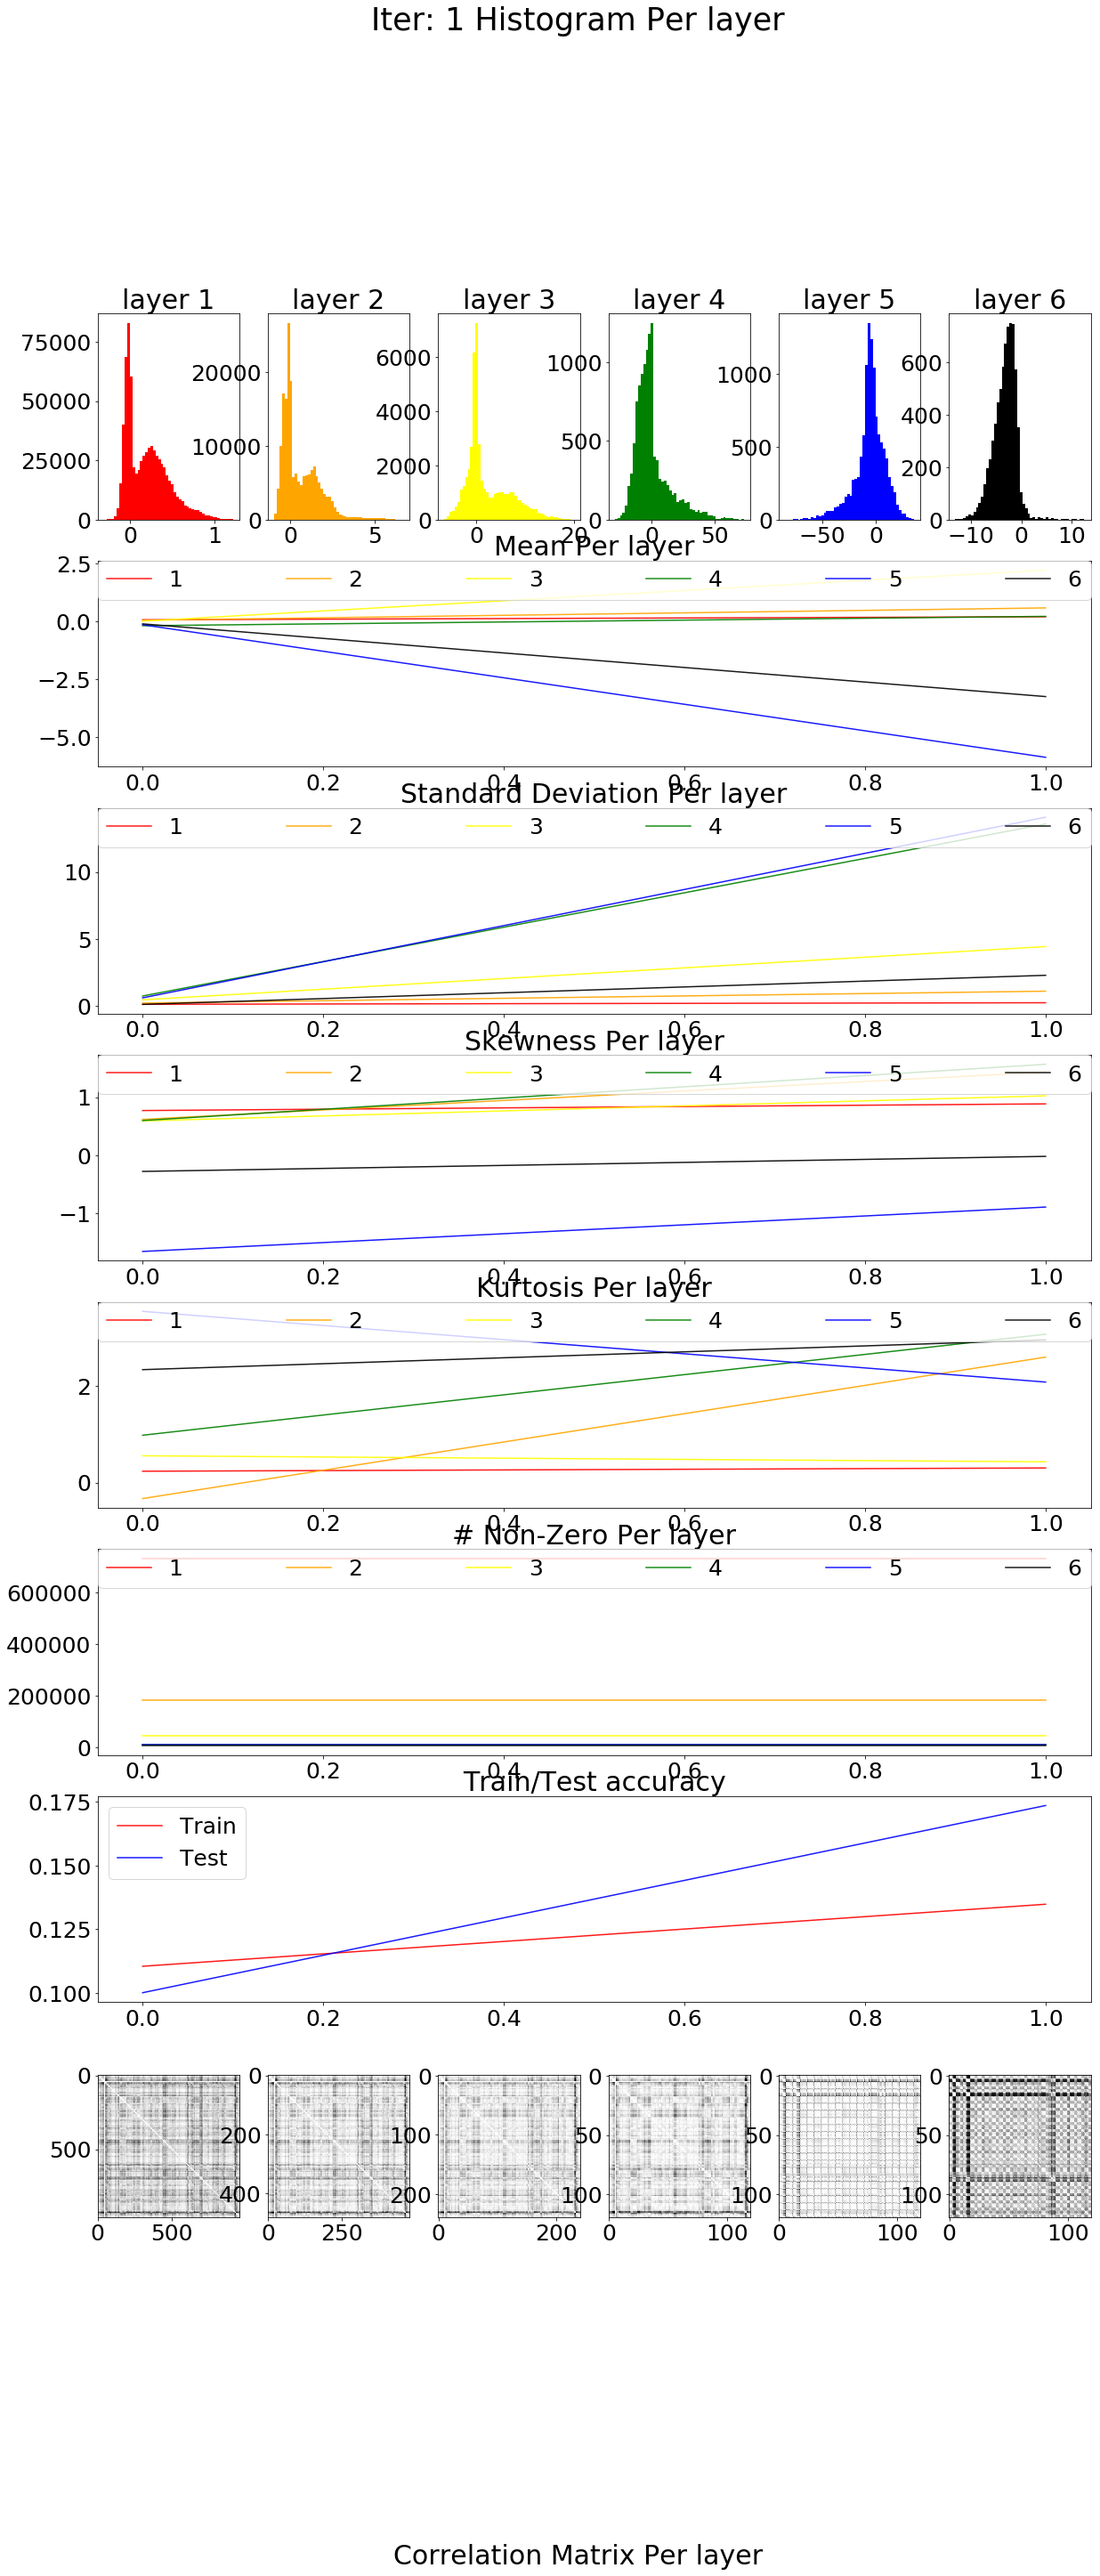

In [6]:
# A
current_exp_name = 'A';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%xdel train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%xdel weight1,weight2,weight3,weight4,weight5,weight6
%xdel gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%xdel gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%xdel gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

In [ ]:
# B
current_exp_name = 'B';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%xdel train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%xdel weight1,weight2,weight3,weight4,weight5,weight6
%xdel gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%xdel gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%xdel gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

In [ ]:
# C
current_exp_name = 'C';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%xdel train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%xdel weight1,weight2,weight3,weight4,weight5,weight6
%xdel gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%xdel gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%xdel gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

In [ ]:
# D
current_exp_name = 'D';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%xdel train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%xdel weight1,weight2,weight3,weight4,weight5,weight6
%xdel gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%xdel gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%xdel gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

In [ ]:
# E
current_exp_name = 'E';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%xdel train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%xdel weight1,weight2,weight3,weight4,weight5,weight6
%xdel gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%xdel gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%xdel gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

In [ ]:
# F
current_exp_name = 'F';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%xdel train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%xdel weight1,weight2,weight3,weight4,weight5,weight6
%xdel gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%xdel gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%xdel gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

In [ ]:
# G
current_exp_name = 'G';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%xdel train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%xdel weight1,weight2,weight3,weight4,weight5,weight6
%xdel gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%xdel gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%xdel gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

In [ ]:
# H
current_exp_name = 'H';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%xdel train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%xdel weight1,weight2,weight3,weight4,weight5,weight6
%xdel gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%xdel gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%xdel gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

In [ ]:
# I
current_exp_name = 'I';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%xdel train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%xdel weight1,weight2,weight3,weight4,weight5,weight6
%xdel gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%xdel gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%xdel gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

In [ ]:
# J
current_exp_name = 'J';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%xdel train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%xdel weight1,weight2,weight3,weight4,weight5,weight6
%xdel gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%xdel gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%xdel gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

In [ ]:
! start .